<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Sparse_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

# Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some L1 regularization to the coding layer’s activations (the decoder is just a regular decoder):

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = Sequential()
simple_encoder.add( Flatten(input_shape=[28,28]) )
simple_encoder.add( Dense(100, activation='selu') )
simple_encoder.add( Dense(30, activation='sigmoid') ) # ensure that the coding values range from 0 to 1

simple_decoder = Sequential()
simple_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
simple_decoder.add( Dense(28*28, activation='sigmoid') )
simple_decoder.add( Reshape([28,28]) )

simple_autoencoder = Sequential([simple_encoder, simple_decoder])
simple_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.), metrics=['binary_accuracy'])

In [ ]:
history = simple_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4933 - binary_accuracy: 0.4762 - val_loss: 0.3790 - val_binary_accuracy: 0.4941
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3712 - binary_accuracy: 0.4970 - val_loss: 0.3542 - val_binary_accuracy: 0.4956
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3468 - binary_accuracy: 0.5006 - val_loss: 0.3367 - val_binary_accuracy: 0.4988
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3315 - binary_accuracy: 0.5033 - val_loss: 0.3264 - val_binary_accuracy: 0.4998
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3234 - binary_accuracy: 0.5033 - val_loss: 0.3225 - val_binary_accuracy: 0.5018
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3189 - binary_accuracy: 0.5042 - val_loss: 0.3184 - val_binary_accuracy: 0.5015
Epoch 7/10
1563/1563 [==============================

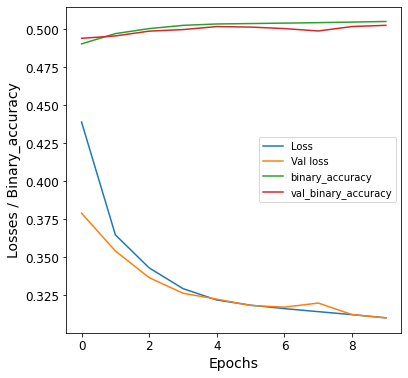

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

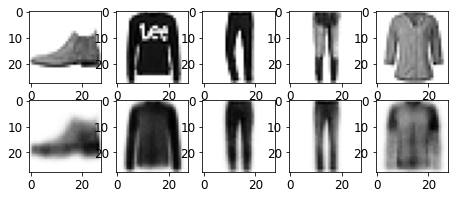

In [ ]:
# Plot the reconstructed images
show_reconstructions(simple_autoencoder, images=X_test)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
  X_valid_codings = encoder(X_valid).numpy()
  activation_means = X_valid_codings.mean(axis=0)
  mean = activation_means.mean()
  bins = np.linspace(0, 1, n_bins + 1)

  fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
  plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
  ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
  ax1.legend(loc="upper center", fontsize=14)
  ax1.set_xlabel("Activation")
  ax1.set_ylabel("% Activations")
  ax1.axis([0, 1, 0, height])
  plot_percent_hist(ax2, activation_means, bins)
  ax2.plot([mean, mean], [0, height], "k--")
  ax2.set_xlabel("Neuron Mean Activation")
  ax2.set_ylabel("% Neurons")
  ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

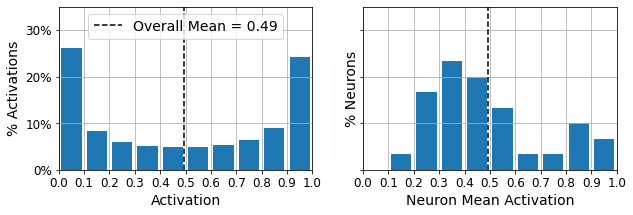

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add L1 regularization to the coding layer:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

l1_encoder = Sequential()
l1_encoder.add( Flatten(input_shape=[28,28]) )
l1_encoder.add( Dense(100, activation='selu') )
l1_encoder.add( Dense(300, activation='sigmoid') ) # ensure that the coding values range from 0 to 1
l1_encoder.add( ActivityRegularization(l1=1e-3) )
# Alternatively, you could add activity_regularizer=keras.regularizers.l1(1e-3) to the previous layer.

l1_decoder = Sequential()
l1_decoder.add( Dense(100, activation='selu', input_shape=[300]) )
l1_decoder.add( Dense(28*28, activation='sigmoid') )
l1_decoder.add( Reshape([28,28]) )

l1_autoencoder = Sequential([l1_encoder, l1_decoder])
l1_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.), metrics=['binary_accuracy'])

This ActivityRegularization layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). Equivalently, you could remove the ActivityRegularization layer and set activity_regularizer=keras.regularizers.l1(1e-3) in the previous layer.

This penalty will encourage the neural network to produce codings close to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the ℓ1 norm rather than the ℓ2 norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

In [ ]:
history = l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.5040 - binary_accuracy: 0.4862 - val_loss: 0.3810 - val_binary_accuracy: 0.4936
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3757 - binary_accuracy: 0.4972 - val_loss: 0.3651 - val_binary_accuracy: 0.4948
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3608 - binary_accuracy: 0.4989 - val_loss: 0.3534 - val_binary_accuracy: 0.4962
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3490 - binary_accuracy: 0.5009 - val_loss: 0.3479 - val_binary_accuracy: 0.4950
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3415 - binary_accuracy: 0.5007 - val_loss: 0.3388 - val_binary_accuracy: 0.4996
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3350 - binary_accuracy: 0.5021 - val_loss: 0.3333 - val_binary_accuracy: 0.4984
Epoch 7/10
1563/1563 [==============================

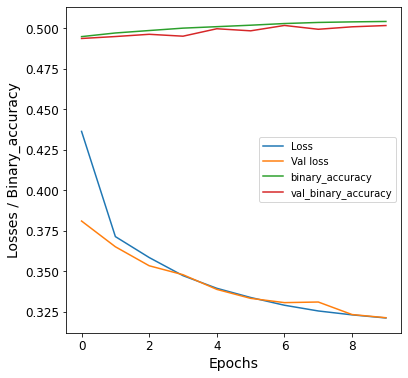

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

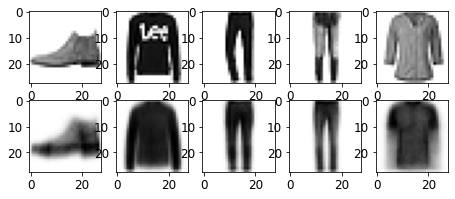

In [ ]:
# Plot the reconstructed images
show_reconstructions(l1_autoencoder, images=X_test)
plt.show()

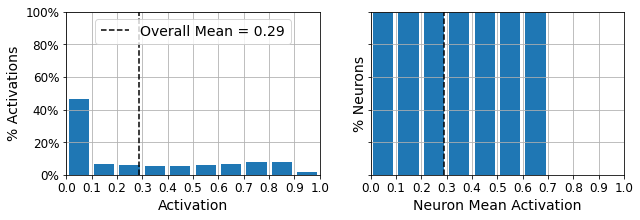

In [ ]:
plot_activations_histogram(l1_autoencoder, height=1.)
plt.show()

## Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%

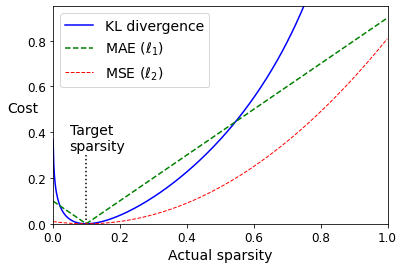

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
# save_fig("sparsity_loss_plot")
plt.show()

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# KL Divergence Regularizer
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = Sequential()
sparse_kl_encoder.add( Flatten(input_shape=[28,28]) )
sparse_kl_encoder.add( Dense(100, activation='selu') )
sparse_kl_encoder.add( Dense(300,activation='sigmoid', activity_regularizer=kld_reg) )


sparse_kl_decoder = Sequential()
sparse_kl_decoder.add( Dense(100, activation='selu', input_shape=[300]) )
sparse_kl_decoder.add( Dense(28*28, activation='sigmoid') )
sparse_kl_decoder.add( Reshape([28, 28]) )


sparse_kl_autoencoder = Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4820 - binary_accuracy: 0.4869 - val_loss: 0.3726 - val_binary_accuracy: 0.4929
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3643 - binary_accuracy: 0.4975 - val_loss: 0.3482 - val_binary_accuracy: 0.4961
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3402 - binary_accuracy: 0.5012 - val_loss: 0.3325 - val_binary_accuracy: 0.4989
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3266 - binary_accuracy: 0.5039 - val_loss: 0.3223 - val_binary_accuracy: 0.5013
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3199 - binary_accuracy: 0.5041 - val_loss: 0.3187 - val_binary_accuracy: 0.5016
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3154 - binary_accuracy: 0.5052 - val_loss: 0.3153 - val_binary_accuracy: 0.5026
Epoch 7/10
1563/1563 [==============================

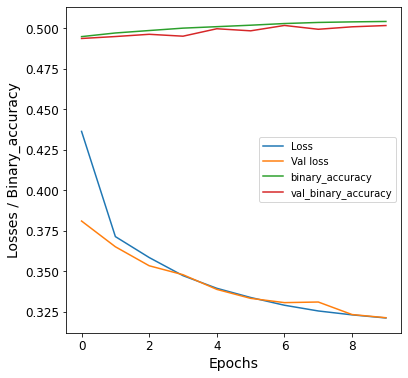

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

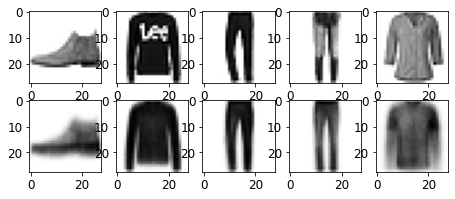

In [ ]:
# Plot the reconstructed images
show_reconstructions(sparse_kl_autoencoder, images=X_test)
plt.show()

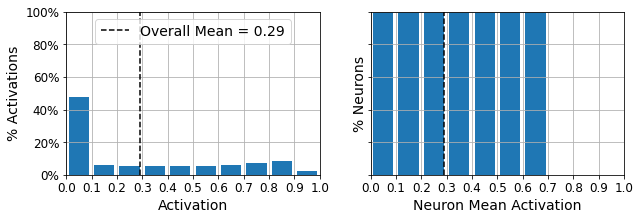

In [ ]:
plot_activations_histogram(sparse_kl_autoencoder)
plt.show()